In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [65]:
torch.manual_seed(1)    # reproducible

In [3]:
class Formal_language_data():
    def __init__(self, seq_length, data_size, character_type = ('a', 'b')):
        self.seq_length = seq_length
        self.data_size = data_size
        self.character_type = character_type
    
    def sample_numbers(self):
        data_list = []
        if len(self.character_type) == 2:
            max_n = self.seq_length // 2
            n_array = np.random.randint(1, max_n+1, self.data_size)
            for n in n_array:
                data = self.character_type[0]*n + self.character_type[1]*n
                data_list.append((data,1))

        elif len(self.character_type) == 3:
            max_n = self.seq_length // 3
            n_array = np.random.randint(1, max_n+1, self.data_size)
            for n in n_array:
                data = self.character_type[0]*n + self.character_type[1]*n + self.character_type[2]*n
                data_list.append((data,1))
        return data_list
    
    def sample_non_numbers(self):
        data_list = []
        if len(self.character_type) == 2:
            n_array = np.random.randint(1, self.seq_length, self.data_size) # sample a number between 1~seq_length-1
            m_array = self.seq_length - n_array
            for i in range(len(n_array)):
                data = self.character_type[0]*n_array[i] + self.character_type[1]*m_array[i]
                data_list.append((data,0))

        elif len(self.character_type) == 3:
            target_sum = np.random.randint(3, self.seq_length + 1, self.data_size) # sample a number between 3~seq_length
            n = np.random.randint(1, target_sum - 1)
            m = np.random.randint(1, target_sum - n)
            k = target_sum - n - m
            for i in range(len(n)):
                data = self.character_type[0]*n[i] + self.character_type[1]*m[i] + self.character_type[2]*k[i]
                data_list.append((data,0))
        return data_list
    
    def test_data(self, data_size):
        data_list = []
        if len(self.character_type) == 2:
            n = np.array([i for i in range(22, 22 + data_size * 2, 2)]) // 2
            for i in range(len(n)):
                data = self.character_type[0]*n[i] + self.character_type[1]*n[i]
                data_list.append((data,1))
        elif len(self.character_type) == 3:
            n = np.array([i for i in range(21, 21 + data_size * 3, 3)]) // 3
            for i in range(len(n)):
                data = self.character_type[0]*n[i] + self.character_type[1]*n[i] + self.character_type[2]*n[i]
                data_list.append((data,1))
        return data_list

In [4]:
class Formal_language_dataset(Dataset):
    def __init__(self, data, max_length):
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence, label = self.data[idx]
        sequence_tensor = torch.tensor([ord(c) - ord('a') + 1 for c in sequence], dtype=torch.long)  # Convert sequence to tensor, where a = 1, b = 2, c=3.
        sequence_pad = torch.zeros(self.max_length, dtype=torch.long)
        sequence_pad[:len(sequence_tensor)] = sequence_tensor
        return sequence_pad, label        

In [5]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.float()
        x = x.unsqueeze(-1) # add one dimension -> (batch_size, seq_length, 1)
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # (num_layers, batch_size, hidden_size)
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [6]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.float()
        x = x.unsqueeze(-1) # add one dimension -> (batch_size, seq_length, 1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # (num_layers, batch_size, hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # (num_layers, batch_size, hidden_size)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [7]:
def training_loop(model, train_loader, optimizer, epochs, device, criterion):
    # Training loop
    train_history = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for i, (data, labels) in enumerate(tqdm(train_loader)):
            # Forward pass
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_loss = train_loss / len(train_loader.dataset)
        train_history.append(avg_loss)
        print('====> Epoch: {} Average loss: {:.10f}'.format(epoch, avg_loss))
    return train_history

def evaluate_model(model, test_loader, device):
    # Initialize dictionary for predictions and labels
    accuracies = []
    lengths = []

    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            # Move data and labels to the correct device
            data = data.to(device)
            labels = labels.to(device)
    
            # Make predictions
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)

            # Store predictions and labels
            mask = data.ne(0)
            # Calculate the number of non-padding tokens in each sequence
            num_non_padding = mask.sum(dim=1)
            length = num_non_padding.item()
            # Calculate accuracy
            total_preds = labels.size(0)
            correct_preds = (predicted == labels).sum().item()
            accuracy = correct_preds / total_preds
            
            accuracies.append(accuracy)
            lengths.append(length)

    return lengths, accuracies

# Define Dataset

In [59]:
seq_length = 20
data_size = 10000
batch_size = 64

two_char = Formal_language_data(seq_length, data_size, ('a', 'b'))
two_char_data = two_char.sample_numbers() + two_char.sample_non_numbers()

three_char = Formal_language_data(seq_length, data_size, ('a', 'b', 'c'))
three_char_data = three_char.sample_numbers() + three_char.sample_non_numbers()

# Create the train dataset object
two_char_dataset = Formal_language_dataset(two_char_data, seq_length)

three_char_dataset = Formal_language_dataset(three_char_data, seq_length)

print("The length of the two character training dataset is: {}".format(len(two_char_dataset)))
print("The length of the three character training dataset is: {}".format(len(three_char_dataset)))

# Create the test dataset object
two_char_test = two_char.test_data(data_size=200)
two_char_test_dataset = Formal_language_dataset(two_char_test, max_length=420)

three_char_test = three_char.test_data(data_size=200)
three_char_test_dataset = Formal_language_dataset(three_char_test, max_length=618)

print("The length of the two character test dataset is: {}".format(len(two_char_test_dataset)))
print("The length of the three character test dataset is: {}".format(len(three_char_test_dataset)))

The length of the two character training dataset is: 20000
The length of the three character training dataset is: 20000
The length of the two character test dataset is: 200
The length of the three character test dataset is: 200


# Train models

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define mdoels
rnn_1 = SimpleRNN(input_size=1, hidden_size=64, num_layers=2, num_classes=2).to(device)
rnn_2 = SimpleRNN(input_size=1, hidden_size=32, num_layers=2, num_classes=2).to(device)
lstm_1 = SimpleLSTM(input_size=1, hidden_size=128, num_layers=3, num_classes=2).to(device)
lstm_2 = SimpleLSTM(input_size=1, hidden_size=32, num_layers=1, num_classes=2).to(device)

# Define optimizer and loss function
rnn_1_optimizer = torch.optim.Adam(rnn_1.parameters(), lr=0.001571)
rnn_2_optimizer = torch.optim.Adam(rnn_2.parameters(), lr=0.008507)
lstm_1_optimizer = torch.optim.Adam(lstm_1.parameters(), lr=0.02004)
lstm_2_optimizer = torch.optim.Adam(lstm_2.parameters(), lr=0.09217)

criterion = nn.CrossEntropyLoss()

# Define training parameters
rnn_1_epochs = 100
rnn_2_epochs = 100
lstm_1_epochs = 50
lstm_2_epochs = 100

# Data loaders
rnn_1_dataloader = DataLoader(two_char_dataset, batch_size=128, shuffle=True)
rnn_2_dataloader = DataLoader(three_char_dataset, batch_size=256, shuffle=True)
lstm_1_dataloader = DataLoader(two_char_dataset, batch_size=256, shuffle=True)
lstm_2_dataloader = DataLoader(three_char_dataset, batch_size=256, shuffle=True)


In [21]:
training_loop(rnn_1, rnn_1_dataloader, rnn_1_optimizer, rnn_1_epochs, device, criterion)

100%|██████████| 157/157 [00:01<00:00, 84.87it/s]


====> Epoch: 0 Average loss: 0.0009078916


100%|██████████| 157/157 [00:01<00:00, 108.20it/s]


====> Epoch: 1 Average loss: 0.0004823144


100%|██████████| 157/157 [00:01<00:00, 108.04it/s]


====> Epoch: 2 Average loss: 0.0004130662


100%|██████████| 157/157 [00:01<00:00, 104.63it/s]


====> Epoch: 3 Average loss: 0.0004361411


100%|██████████| 157/157 [00:01<00:00, 106.68it/s]


====> Epoch: 4 Average loss: 0.0004011690


100%|██████████| 157/157 [00:01<00:00, 103.14it/s]


====> Epoch: 5 Average loss: 0.0004019293


100%|██████████| 157/157 [00:01<00:00, 108.07it/s]


====> Epoch: 6 Average loss: 0.0003989639


100%|██████████| 157/157 [00:01<00:00, 97.84it/s] 


====> Epoch: 7 Average loss: 0.0003902531


100%|██████████| 157/157 [00:01<00:00, 106.40it/s]


====> Epoch: 8 Average loss: 0.0004046284


100%|██████████| 157/157 [00:01<00:00, 104.56it/s]


====> Epoch: 9 Average loss: 0.0006503428


100%|██████████| 157/157 [00:01<00:00, 100.84it/s]


====> Epoch: 10 Average loss: 0.0005655892


100%|██████████| 157/157 [00:01<00:00, 111.41it/s]


====> Epoch: 11 Average loss: 0.0004010639


100%|██████████| 157/157 [00:01<00:00, 110.31it/s]


====> Epoch: 12 Average loss: 0.0003929461


100%|██████████| 157/157 [00:01<00:00, 101.44it/s]


====> Epoch: 13 Average loss: 0.0003938408


100%|██████████| 157/157 [00:01<00:00, 111.24it/s]


====> Epoch: 14 Average loss: 0.0004029194


100%|██████████| 157/157 [00:01<00:00, 109.04it/s]


====> Epoch: 15 Average loss: 0.0003966754


100%|██████████| 157/157 [00:01<00:00, 112.33it/s]


====> Epoch: 16 Average loss: 0.0003859027


100%|██████████| 157/157 [00:01<00:00, 113.25it/s]


====> Epoch: 17 Average loss: 0.0003847094


100%|██████████| 157/157 [00:01<00:00, 112.79it/s]


====> Epoch: 18 Average loss: 0.0003846443


100%|██████████| 157/157 [00:01<00:00, 107.41it/s]


====> Epoch: 19 Average loss: 0.0003860810


100%|██████████| 157/157 [00:01<00:00, 112.98it/s]


====> Epoch: 20 Average loss: 0.0003871294


100%|██████████| 157/157 [00:01<00:00, 111.98it/s]


====> Epoch: 21 Average loss: 0.0003864448


100%|██████████| 157/157 [00:01<00:00, 112.28it/s]


====> Epoch: 22 Average loss: 0.0003809563


100%|██████████| 157/157 [00:01<00:00, 105.64it/s]


====> Epoch: 23 Average loss: 0.0003837632


100%|██████████| 157/157 [00:01<00:00, 108.94it/s]


====> Epoch: 24 Average loss: 0.0003821532


100%|██████████| 157/157 [00:01<00:00, 109.01it/s]


====> Epoch: 25 Average loss: 0.0003866226


100%|██████████| 157/157 [00:01<00:00, 109.40it/s]


====> Epoch: 26 Average loss: 0.0003844241


100%|██████████| 157/157 [00:01<00:00, 106.58it/s]


====> Epoch: 27 Average loss: 0.0003899960


100%|██████████| 157/157 [00:01<00:00, 112.36it/s]


====> Epoch: 28 Average loss: 0.0003867262


100%|██████████| 157/157 [00:01<00:00, 111.58it/s]


====> Epoch: 29 Average loss: 0.0003837163


100%|██████████| 157/157 [00:01<00:00, 108.21it/s]


====> Epoch: 30 Average loss: 0.0003828151


100%|██████████| 157/157 [00:01<00:00, 103.27it/s]


====> Epoch: 31 Average loss: 0.0004613233


100%|██████████| 157/157 [00:01<00:00, 108.35it/s]


====> Epoch: 32 Average loss: 0.0003996488


100%|██████████| 157/157 [00:01<00:00, 108.00it/s]


====> Epoch: 33 Average loss: 0.0003862879


100%|██████████| 157/157 [00:01<00:00, 107.39it/s]


====> Epoch: 34 Average loss: 0.0003878984


100%|██████████| 157/157 [00:01<00:00, 102.04it/s]


====> Epoch: 35 Average loss: 0.0003850288


100%|██████████| 157/157 [00:01<00:00, 106.68it/s]


====> Epoch: 36 Average loss: 0.0003833044


100%|██████████| 157/157 [00:01<00:00, 108.76it/s]


====> Epoch: 37 Average loss: 0.0003847875


100%|██████████| 157/157 [00:01<00:00, 106.37it/s]


====> Epoch: 38 Average loss: 0.0003836643


100%|██████████| 157/157 [00:01<00:00, 102.68it/s]


====> Epoch: 39 Average loss: 0.0003835375


100%|██████████| 157/157 [00:01<00:00, 107.22it/s]


====> Epoch: 40 Average loss: 0.0003863853


100%|██████████| 157/157 [00:01<00:00, 107.59it/s]


====> Epoch: 41 Average loss: 0.0003857413


100%|██████████| 157/157 [00:01<00:00, 107.98it/s]


====> Epoch: 42 Average loss: 0.0003839945


100%|██████████| 157/157 [00:01<00:00, 103.31it/s]


====> Epoch: 43 Average loss: 0.0003838770


100%|██████████| 157/157 [00:01<00:00, 110.41it/s]


====> Epoch: 44 Average loss: 0.0003852217


100%|██████████| 157/157 [00:01<00:00, 106.53it/s]


====> Epoch: 45 Average loss: 0.0003831958


100%|██████████| 157/157 [00:01<00:00, 100.11it/s]


====> Epoch: 46 Average loss: 0.0003825755


100%|██████████| 157/157 [00:01<00:00, 97.69it/s] 


====> Epoch: 47 Average loss: 0.0003842703


100%|██████████| 157/157 [00:01<00:00, 92.88it/s] 


====> Epoch: 48 Average loss: 0.0003850257


100%|██████████| 157/157 [00:01<00:00, 103.90it/s]


====> Epoch: 49 Average loss: 0.0003851968


100%|██████████| 157/157 [00:01<00:00, 106.11it/s]


====> Epoch: 50 Average loss: 0.0003844731


100%|██████████| 157/157 [00:01<00:00, 99.97it/s] 


====> Epoch: 51 Average loss: 0.0003826857


100%|██████████| 157/157 [00:01<00:00, 98.24it/s] 


====> Epoch: 52 Average loss: 0.0003837873


100%|██████████| 157/157 [00:01<00:00, 107.34it/s]


====> Epoch: 53 Average loss: 0.0003881665


100%|██████████| 157/157 [00:01<00:00, 101.12it/s]


====> Epoch: 54 Average loss: 0.0003826885


100%|██████████| 157/157 [00:01<00:00, 98.74it/s] 


====> Epoch: 55 Average loss: 0.0003811589


100%|██████████| 157/157 [00:01<00:00, 93.11it/s] 


====> Epoch: 56 Average loss: 0.0003839366


100%|██████████| 157/157 [00:01<00:00, 100.90it/s]


====> Epoch: 57 Average loss: 0.0003852335


100%|██████████| 157/157 [00:01<00:00, 106.85it/s]


====> Epoch: 58 Average loss: 0.0003826440


100%|██████████| 157/157 [00:01<00:00, 103.96it/s]


====> Epoch: 59 Average loss: 0.0003828679


100%|██████████| 157/157 [00:01<00:00, 95.76it/s] 


====> Epoch: 60 Average loss: 0.0003825532


100%|██████████| 157/157 [00:01<00:00, 101.72it/s]


====> Epoch: 61 Average loss: 0.0003831923


100%|██████████| 157/157 [00:01<00:00, 107.33it/s]


====> Epoch: 62 Average loss: 0.0003835975


100%|██████████| 157/157 [00:01<00:00, 107.60it/s]


====> Epoch: 63 Average loss: 0.0003853047


100%|██████████| 157/157 [00:01<00:00, 107.32it/s]


====> Epoch: 64 Average loss: 0.0007341906


100%|██████████| 157/157 [00:01<00:00, 102.19it/s]


====> Epoch: 65 Average loss: 0.0011728581


100%|██████████| 157/157 [00:01<00:00, 106.67it/s]


====> Epoch: 66 Average loss: 0.0004098406


100%|██████████| 157/157 [00:01<00:00, 106.88it/s]


====> Epoch: 67 Average loss: 0.0003884491


100%|██████████| 157/157 [00:01<00:00, 106.69it/s]


====> Epoch: 68 Average loss: 0.0003885930


100%|██████████| 157/157 [00:01<00:00, 102.48it/s]


====> Epoch: 69 Average loss: 0.0003853292


100%|██████████| 157/157 [00:01<00:00, 110.84it/s]


====> Epoch: 70 Average loss: 0.0003870152


100%|██████████| 157/157 [00:01<00:00, 110.49it/s]


====> Epoch: 71 Average loss: 0.0003829729


100%|██████████| 157/157 [00:01<00:00, 108.08it/s]


====> Epoch: 72 Average loss: 0.0003863390


100%|██████████| 157/157 [00:01<00:00, 104.22it/s]


====> Epoch: 73 Average loss: 0.0003860135


100%|██████████| 157/157 [00:01<00:00, 107.52it/s]


====> Epoch: 74 Average loss: 0.0003849131


100%|██████████| 157/157 [00:01<00:00, 106.41it/s]


====> Epoch: 75 Average loss: 0.0003823103


100%|██████████| 157/157 [00:01<00:00, 107.39it/s]


====> Epoch: 76 Average loss: 0.0003831410


100%|██████████| 157/157 [00:01<00:00, 103.24it/s]


====> Epoch: 77 Average loss: 0.0003812081


100%|██████████| 157/157 [00:01<00:00, 110.37it/s]


====> Epoch: 78 Average loss: 0.0003833042


100%|██████████| 157/157 [00:01<00:00, 111.83it/s]


====> Epoch: 79 Average loss: 0.0004989100


100%|██████████| 157/157 [00:01<00:00, 110.53it/s]


====> Epoch: 80 Average loss: 0.0003869259


100%|██████████| 157/157 [00:01<00:00, 106.21it/s]


====> Epoch: 81 Average loss: 0.0003848918


100%|██████████| 157/157 [00:01<00:00, 111.10it/s]


====> Epoch: 82 Average loss: 0.0003847129


100%|██████████| 157/157 [00:01<00:00, 111.24it/s]


====> Epoch: 83 Average loss: 0.0003859407


100%|██████████| 157/157 [00:01<00:00, 109.27it/s]


====> Epoch: 84 Average loss: 0.0003888134


100%|██████████| 157/157 [00:01<00:00, 107.25it/s]


====> Epoch: 85 Average loss: 0.0003855361


100%|██████████| 157/157 [00:01<00:00, 103.77it/s]


====> Epoch: 86 Average loss: 0.0003843639


100%|██████████| 157/157 [00:01<00:00, 107.56it/s]


====> Epoch: 87 Average loss: 0.0003858936


100%|██████████| 157/157 [00:01<00:00, 110.22it/s]


====> Epoch: 88 Average loss: 0.0003841901


100%|██████████| 157/157 [00:01<00:00, 110.68it/s]


====> Epoch: 89 Average loss: 0.0003840460


100%|██████████| 157/157 [00:01<00:00, 106.20it/s]


====> Epoch: 90 Average loss: 0.0003856195


100%|██████████| 157/157 [00:01<00:00, 110.73it/s]


====> Epoch: 91 Average loss: 0.0003885823


100%|██████████| 157/157 [00:01<00:00, 106.94it/s]


====> Epoch: 92 Average loss: 0.0011237986


100%|██████████| 157/157 [00:01<00:00, 93.49it/s]


====> Epoch: 93 Average loss: 0.0012925673


100%|██████████| 157/157 [00:01<00:00, 102.25it/s]


====> Epoch: 94 Average loss: 0.0012925509


100%|██████████| 157/157 [00:01<00:00, 110.57it/s]


====> Epoch: 95 Average loss: 0.0008119714


100%|██████████| 157/157 [00:01<00:00, 111.43it/s]


====> Epoch: 96 Average loss: 0.0003906412


100%|██████████| 157/157 [00:01<00:00, 109.01it/s]


====> Epoch: 97 Average loss: 0.0003843380


100%|██████████| 157/157 [00:01<00:00, 105.18it/s]


====> Epoch: 98 Average loss: 0.0003874194


100%|██████████| 157/157 [00:01<00:00, 112.20it/s]

====> Epoch: 99 Average loss: 0.0003855013


[0.000907891566772014,
 0.0004823143649380654,
 0.0004130662411917001,
 0.00043614105926826594,
 0.0004011689874809235,
 0.00040192933259531856,
 0.0003989639295032248,
 0.0003902530825231224,
 0.0004046283607371151,
 0.0006503427966497838,
 0.0005655892048031092,
 0.0004010639139916748,
 0.0003929460549261421,
 0.0003938407809007913,
 0.00040291941617615523,
 0.00039667538274079563,
 0.000385902707464993,
 0.0003847094441727677,
 0.00038464426500722765,
 0.00038608099441044035,
 0.00038712942483834923,
 0.00038644478172063826,
 0.0003809562819544226,
 0.00038376319468952716,
 0.00038215323449112474,
 0.0003866226252634078,
 0.00038442407858092336,
 0.0003899960075970739,
 0.00038672618102282287,
 0.000383716288395226,
 0.00038281510465312747,
 0.00046132331248372794,
 0.0003996487797005102,
 0.0003862878605723381,
 0.00038789835907518866,
 0.0003850287728942931,
 0.0003833043688908219,
 0.0003847875042818487,
 0.000383664321154356,
 0.00038353748703375456,
 0.0003863852730719373,
 0.0

In [22]:
training_loop(rnn_2, rnn_2_dataloader, rnn_2_optimizer, rnn_2_epochs, device, criterion)

100%|██████████| 79/79 [00:00<00:00, 85.36it/s]


====> Epoch: 0 Average loss: 0.0016588521


100%|██████████| 79/79 [00:00<00:00, 91.28it/s]


====> Epoch: 1 Average loss: 0.0014643990


100%|██████████| 79/79 [00:00<00:00, 85.60it/s]


====> Epoch: 2 Average loss: 0.0015170125


100%|██████████| 79/79 [00:00<00:00, 92.26it/s]


====> Epoch: 3 Average loss: 0.0014776959


100%|██████████| 79/79 [00:00<00:00, 91.81it/s]


====> Epoch: 4 Average loss: 0.0014758527


100%|██████████| 79/79 [00:00<00:00, 92.79it/s]


====> Epoch: 5 Average loss: 0.0016930809


100%|██████████| 79/79 [00:00<00:00, 92.84it/s]


====> Epoch: 6 Average loss: 0.0014868126


100%|██████████| 79/79 [00:00<00:00, 91.89it/s]


====> Epoch: 7 Average loss: 0.0014918637


100%|██████████| 79/79 [00:00<00:00, 91.72it/s]


====> Epoch: 8 Average loss: 0.0014738739


100%|██████████| 79/79 [00:00<00:00, 91.12it/s]


====> Epoch: 9 Average loss: 0.0014766327


100%|██████████| 79/79 [00:00<00:00, 83.56it/s]


====> Epoch: 10 Average loss: 0.0014839780


100%|██████████| 79/79 [00:00<00:00, 91.99it/s]


====> Epoch: 11 Average loss: 0.0014833065


100%|██████████| 79/79 [00:00<00:00, 96.15it/s]


====> Epoch: 12 Average loss: 0.0014786955


100%|██████████| 79/79 [00:00<00:00, 95.22it/s]


====> Epoch: 13 Average loss: 0.0014751005


100%|██████████| 79/79 [00:00<00:00, 95.48it/s]


====> Epoch: 14 Average loss: 0.0014765105


100%|██████████| 79/79 [00:00<00:00, 96.09it/s]


====> Epoch: 15 Average loss: 0.0014898746


100%|██████████| 79/79 [00:00<00:00, 95.78it/s]


====> Epoch: 16 Average loss: 0.0014650268


100%|██████████| 79/79 [00:00<00:00, 88.38it/s]


====> Epoch: 17 Average loss: 0.0014565003


100%|██████████| 79/79 [00:00<00:00, 91.88it/s]


====> Epoch: 18 Average loss: 0.0014817660


100%|██████████| 79/79 [00:00<00:00, 91.85it/s]


====> Epoch: 19 Average loss: 0.0014799751


100%|██████████| 79/79 [00:00<00:00, 93.35it/s]


====> Epoch: 20 Average loss: 0.0014822910


100%|██████████| 79/79 [00:00<00:00, 92.00it/s]


====> Epoch: 21 Average loss: 0.0016910256


100%|██████████| 79/79 [00:00<00:00, 92.34it/s]


====> Epoch: 22 Average loss: 0.0014862124


100%|██████████| 79/79 [00:00<00:00, 92.34it/s]


====> Epoch: 23 Average loss: 0.0014709979


100%|██████████| 79/79 [00:00<00:00, 85.36it/s]


====> Epoch: 24 Average loss: 0.0014534735


100%|██████████| 79/79 [00:00<00:00, 91.28it/s]


====> Epoch: 25 Average loss: 0.0029706017


100%|██████████| 79/79 [00:00<00:00, 91.51it/s]


====> Epoch: 26 Average loss: 0.0027426877


100%|██████████| 79/79 [00:00<00:00, 90.28it/s]


====> Epoch: 27 Average loss: 0.0027362803


100%|██████████| 79/79 [00:00<00:00, 93.20it/s]


====> Epoch: 28 Average loss: 0.0027511773


100%|██████████| 79/79 [00:00<00:00, 93.63it/s]


====> Epoch: 29 Average loss: 0.0026340949


100%|██████████| 79/79 [00:00<00:00, 86.52it/s]


====> Epoch: 30 Average loss: 0.0016232449


100%|██████████| 79/79 [00:00<00:00, 93.52it/s]


====> Epoch: 31 Average loss: 0.0014798246


100%|██████████| 79/79 [00:00<00:00, 92.89it/s]


====> Epoch: 32 Average loss: 0.0014695980


100%|██████████| 79/79 [00:00<00:00, 93.49it/s]


====> Epoch: 33 Average loss: 0.0014797079


100%|██████████| 79/79 [00:00<00:00, 94.04it/s]


====> Epoch: 34 Average loss: 0.0014742400


100%|██████████| 79/79 [00:00<00:00, 94.39it/s]


====> Epoch: 35 Average loss: 0.0014750517


100%|██████████| 79/79 [00:00<00:00, 92.01it/s]


====> Epoch: 36 Average loss: 0.0014649644


100%|██████████| 79/79 [00:00<00:00, 90.33it/s]


====> Epoch: 37 Average loss: 0.0020372732


100%|██████████| 79/79 [00:00<00:00, 91.51it/s]


====> Epoch: 38 Average loss: 0.0018980358


100%|██████████| 79/79 [00:00<00:00, 90.90it/s]


====> Epoch: 39 Average loss: 0.0015149710


100%|██████████| 79/79 [00:00<00:00, 89.51it/s]


====> Epoch: 40 Average loss: 0.0014943119


100%|██████████| 79/79 [00:00<00:00, 87.48it/s]


====> Epoch: 41 Average loss: 0.0014838826


100%|██████████| 79/79 [00:00<00:00, 85.55it/s]


====> Epoch: 42 Average loss: 0.0014832572


100%|██████████| 79/79 [00:01<00:00, 77.52it/s]


====> Epoch: 43 Average loss: 0.0014850159


100%|██████████| 79/79 [00:00<00:00, 83.07it/s]


====> Epoch: 44 Average loss: 0.0014804289


100%|██████████| 79/79 [00:00<00:00, 81.56it/s]


====> Epoch: 45 Average loss: 0.0014847832


100%|██████████| 79/79 [00:00<00:00, 79.05it/s]


====> Epoch: 46 Average loss: 0.0014759691


100%|██████████| 79/79 [00:00<00:00, 81.45it/s]


====> Epoch: 47 Average loss: 0.0014778190


100%|██████████| 79/79 [00:00<00:00, 80.81it/s]


====> Epoch: 48 Average loss: 0.0014819981


100%|██████████| 79/79 [00:01<00:00, 74.54it/s]


====> Epoch: 49 Average loss: 0.0014827950


100%|██████████| 79/79 [00:00<00:00, 80.83it/s]


====> Epoch: 50 Average loss: 0.0014822396


100%|██████████| 79/79 [00:00<00:00, 80.13it/s]


====> Epoch: 51 Average loss: 0.0014735446


100%|██████████| 79/79 [00:00<00:00, 81.35it/s]


====> Epoch: 52 Average loss: 0.0014777703


100%|██████████| 79/79 [00:00<00:00, 79.71it/s]


====> Epoch: 53 Average loss: 0.0014812146


100%|██████████| 79/79 [00:01<00:00, 78.76it/s]


====> Epoch: 54 Average loss: 0.0014837924


100%|██████████| 79/79 [00:01<00:00, 73.37it/s]


====> Epoch: 55 Average loss: 0.0014799151


100%|██████████| 79/79 [00:00<00:00, 79.46it/s]


====> Epoch: 56 Average loss: 0.0014805818


100%|██████████| 79/79 [00:00<00:00, 79.95it/s]


====> Epoch: 57 Average loss: 0.0014783493


100%|██████████| 79/79 [00:00<00:00, 79.80it/s]


====> Epoch: 58 Average loss: 0.0014754043


100%|██████████| 79/79 [00:00<00:00, 79.25it/s]


====> Epoch: 59 Average loss: 0.0014846201


100%|██████████| 79/79 [00:00<00:00, 79.02it/s]


====> Epoch: 60 Average loss: 0.0014719267


100%|██████████| 79/79 [00:01<00:00, 74.01it/s]


====> Epoch: 61 Average loss: 0.0014724535


100%|██████████| 79/79 [00:01<00:00, 78.52it/s]


====> Epoch: 62 Average loss: 0.0014710427


100%|██████████| 79/79 [00:01<00:00, 78.70it/s]


====> Epoch: 63 Average loss: 0.0014951608


100%|██████████| 79/79 [00:00<00:00, 79.12it/s]


====> Epoch: 64 Average loss: 0.0014846480


100%|██████████| 79/79 [00:00<00:00, 79.29it/s]


====> Epoch: 65 Average loss: 0.0014825649


100%|██████████| 79/79 [00:00<00:00, 79.25it/s]


====> Epoch: 66 Average loss: 0.0014812958


100%|██████████| 79/79 [00:01<00:00, 78.89it/s]


====> Epoch: 67 Average loss: 0.0014812151


100%|██████████| 79/79 [00:01<00:00, 74.26it/s]


====> Epoch: 68 Average loss: 0.0014766186


100%|██████████| 79/79 [00:00<00:00, 79.52it/s]


====> Epoch: 69 Average loss: 0.0014677553


100%|██████████| 79/79 [00:00<00:00, 79.73it/s]


====> Epoch: 70 Average loss: 0.0014772234


100%|██████████| 79/79 [00:00<00:00, 79.30it/s]


====> Epoch: 71 Average loss: 0.0014809260


100%|██████████| 79/79 [00:00<00:00, 79.61it/s]


====> Epoch: 72 Average loss: 0.0014815502


100%|██████████| 79/79 [00:00<00:00, 79.37it/s]


====> Epoch: 73 Average loss: 0.0014762114


100%|██████████| 79/79 [00:00<00:00, 80.43it/s]


====> Epoch: 74 Average loss: 0.0014861380


100%|██████████| 79/79 [00:01<00:00, 74.95it/s]


====> Epoch: 75 Average loss: 0.0014836268


100%|██████████| 79/79 [00:01<00:00, 75.66it/s]


====> Epoch: 76 Average loss: 0.0014780458


100%|██████████| 79/79 [00:01<00:00, 76.80it/s]


====> Epoch: 77 Average loss: 0.0014831600


100%|██████████| 79/79 [00:00<00:00, 80.52it/s]


====> Epoch: 78 Average loss: 0.0014945041


100%|██████████| 79/79 [00:00<00:00, 80.48it/s]


====> Epoch: 79 Average loss: 0.0014725223


100%|██████████| 79/79 [00:00<00:00, 80.20it/s]


====> Epoch: 80 Average loss: 0.0014818693


100%|██████████| 79/79 [00:00<00:00, 80.61it/s]


====> Epoch: 81 Average loss: 0.0014678843


100%|██████████| 79/79 [00:01<00:00, 75.39it/s]


====> Epoch: 82 Average loss: 0.0014749936


100%|██████████| 79/79 [00:00<00:00, 81.15it/s]


====> Epoch: 83 Average loss: 0.0014902215


100%|██████████| 79/79 [00:00<00:00, 81.62it/s]


====> Epoch: 84 Average loss: 0.0014854482


100%|██████████| 79/79 [00:00<00:00, 81.82it/s]


====> Epoch: 85 Average loss: 0.0014860750


100%|██████████| 79/79 [00:00<00:00, 81.85it/s]


====> Epoch: 86 Average loss: 0.0014878181


100%|██████████| 79/79 [00:00<00:00, 82.43it/s]


====> Epoch: 87 Average loss: 0.0014852888


100%|██████████| 79/79 [00:00<00:00, 80.21it/s]


====> Epoch: 88 Average loss: 0.0014870224


100%|██████████| 79/79 [00:00<00:00, 83.81it/s]


====> Epoch: 89 Average loss: 0.0014776767


100%|██████████| 79/79 [00:00<00:00, 85.72it/s]


====> Epoch: 90 Average loss: 0.0014850797


100%|██████████| 79/79 [00:00<00:00, 84.09it/s]


====> Epoch: 91 Average loss: 0.0014810677


100%|██████████| 79/79 [00:00<00:00, 83.86it/s]


====> Epoch: 92 Average loss: 0.0014824200


100%|██████████| 79/79 [00:00<00:00, 82.28it/s]


====> Epoch: 93 Average loss: 0.0014790072


100%|██████████| 79/79 [00:01<00:00, 78.57it/s]


====> Epoch: 94 Average loss: 0.0014733549


100%|██████████| 79/79 [00:00<00:00, 84.54it/s]


====> Epoch: 95 Average loss: 0.0014741899


100%|██████████| 79/79 [00:00<00:00, 84.11it/s]


====> Epoch: 96 Average loss: 0.0014778822


100%|██████████| 79/79 [00:00<00:00, 83.87it/s]


====> Epoch: 97 Average loss: 0.0014765791


100%|██████████| 79/79 [00:00<00:00, 84.24it/s]


====> Epoch: 98 Average loss: 0.0014767912


100%|██████████| 79/79 [00:00<00:00, 85.03it/s]

====> Epoch: 99 Average loss: 0.0014837407


[0.001658852082490921,
 0.0014643990263342858,
 0.001517012506723404,
 0.0014776958629488944,
 0.0014758526638150216,
 0.0016930809110403061,
 0.0014868126422166825,
 0.0014918636992573737,
 0.0014738739013671876,
 0.0014766326576471328,
 0.0014839780420064926,
 0.0014833065062761306,
 0.001478695534169674,
 0.0014751004680991172,
 0.0014765104800462724,
 0.0014898745968937874,
 0.0014650268480181695,
 0.0014565002843737603,
 0.0014817660316824913,
 0.0014799751281738282,
 0.0014822910398244859,
 0.0016910255670547485,
 0.0014862124249339103,
 0.0014709979437291622,
 0.0014534735307097436,
 0.002970601709187031,
 0.0027426876962184906,
 0.0027362803131341933,
 0.002751177278161049,
 0.0026340948536992073,
 0.0016232448935508729,
 0.0014798246279358865,
 0.0014695979915559292,
 0.0014797078549861908,
 0.0014742399841547013,
 0.0014750516936182976,
 0.0014649644270539283,
 0.0020372732371091843,
 0.001898035778105259,
 0.0015149710021913052,
 0.0014943118512630463,
 0.0014838825955986977

In [23]:
training_loop(lstm_1, lstm_1_dataloader, lstm_1_optimizer, lstm_1_epochs, device, criterion)

100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


====> Epoch: 0 Average loss: 0.0028114280


100%|██████████| 79/79 [00:20<00:00,  3.92it/s]


====> Epoch: 1 Average loss: 0.0024225163


100%|██████████| 79/79 [00:17<00:00,  4.47it/s]


====> Epoch: 2 Average loss: 0.0006516726


100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


====> Epoch: 3 Average loss: 0.0006412111


100%|██████████| 79/79 [00:18<00:00,  4.34it/s]


====> Epoch: 4 Average loss: 0.0006416878


100%|██████████| 79/79 [00:18<00:00,  4.38it/s]


====> Epoch: 5 Average loss: 0.0006451575


100%|██████████| 79/79 [00:17<00:00,  4.54it/s]


====> Epoch: 6 Average loss: 0.0006440615


100%|██████████| 79/79 [00:17<00:00,  4.48it/s]


====> Epoch: 7 Average loss: 0.0006459417


100%|██████████| 79/79 [00:18<00:00,  4.34it/s]


====> Epoch: 8 Average loss: 0.0006468186


100%|██████████| 79/79 [00:17<00:00,  4.41it/s]


====> Epoch: 9 Average loss: 0.0006544142


100%|██████████| 79/79 [00:17<00:00,  4.46it/s]


====> Epoch: 10 Average loss: 0.0006446541


100%|██████████| 79/79 [00:17<00:00,  4.51it/s]


====> Epoch: 11 Average loss: 0.0006528889


100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


====> Epoch: 12 Average loss: 0.0006432281


100%|██████████| 79/79 [00:18<00:00,  4.34it/s]


====> Epoch: 13 Average loss: 0.0006460050


100%|██████████| 79/79 [00:18<00:00,  4.36it/s]


====> Epoch: 14 Average loss: 0.0006415746


100%|██████████| 79/79 [00:18<00:00,  4.21it/s]


====> Epoch: 15 Average loss: 0.0006482523


100%|██████████| 79/79 [00:17<00:00,  4.46it/s]


====> Epoch: 16 Average loss: 0.0006461312


100%|██████████| 79/79 [00:17<00:00,  4.45it/s]


====> Epoch: 17 Average loss: 0.0006445136


100%|██████████| 79/79 [00:18<00:00,  4.36it/s]


====> Epoch: 18 Average loss: 0.0006482377


100%|██████████| 79/79 [00:18<00:00,  4.29it/s]


====> Epoch: 19 Average loss: 0.0006523914


100%|██████████| 79/79 [00:18<00:00,  4.28it/s]


====> Epoch: 20 Average loss: 0.0006492031


100%|██████████| 79/79 [00:18<00:00,  4.31it/s]


====> Epoch: 21 Average loss: 0.0006514414


100%|██████████| 79/79 [00:18<00:00,  4.38it/s]


====> Epoch: 22 Average loss: 0.0006433818


100%|██████████| 79/79 [00:18<00:00,  4.37it/s]


====> Epoch: 23 Average loss: 0.0006482386


100%|██████████| 79/79 [00:18<00:00,  4.35it/s]


====> Epoch: 24 Average loss: 0.0006485623


100%|██████████| 79/79 [00:17<00:00,  4.44it/s]


====> Epoch: 25 Average loss: 0.0006455387


100%|██████████| 79/79 [00:17<00:00,  4.41it/s]


====> Epoch: 26 Average loss: 0.0006453011


100%|██████████| 79/79 [00:17<00:00,  4.48it/s]


====> Epoch: 27 Average loss: 0.0006450807


100%|██████████| 79/79 [00:17<00:00,  4.48it/s]


====> Epoch: 28 Average loss: 0.0006448511


100%|██████████| 79/79 [00:17<00:00,  4.44it/s]


====> Epoch: 29 Average loss: 0.0006503287


100%|██████████| 79/79 [00:18<00:00,  4.32it/s]


====> Epoch: 30 Average loss: 0.0006420941


100%|██████████| 79/79 [00:18<00:00,  4.35it/s]


====> Epoch: 31 Average loss: 0.0006474780


100%|██████████| 79/79 [00:17<00:00,  4.51it/s]


====> Epoch: 32 Average loss: 0.0006450668


100%|██████████| 79/79 [00:17<00:00,  4.51it/s]


====> Epoch: 33 Average loss: 0.0006489104


100%|██████████| 79/79 [00:17<00:00,  4.54it/s]


====> Epoch: 34 Average loss: 0.0006495967


100%|██████████| 79/79 [00:17<00:00,  4.39it/s]


====> Epoch: 35 Average loss: 0.0006439283


100%|██████████| 79/79 [00:17<00:00,  4.39it/s]


====> Epoch: 36 Average loss: 0.0006494435


100%|██████████| 79/79 [00:18<00:00,  4.30it/s]


====> Epoch: 37 Average loss: 0.0006466458


100%|██████████| 79/79 [00:18<00:00,  4.38it/s]


====> Epoch: 38 Average loss: 0.0006502814


100%|██████████| 79/79 [00:18<00:00,  4.38it/s]


====> Epoch: 39 Average loss: 0.0006552500


100%|██████████| 79/79 [00:17<00:00,  4.43it/s]


====> Epoch: 40 Average loss: 0.0006423008


100%|██████████| 79/79 [00:17<00:00,  4.44it/s]


====> Epoch: 41 Average loss: 0.0006446984


100%|██████████| 79/79 [00:17<00:00,  4.42it/s]


====> Epoch: 42 Average loss: 0.0006512312


100%|██████████| 79/79 [00:17<00:00,  4.42it/s]


====> Epoch: 43 Average loss: 0.0006489184


100%|██████████| 79/79 [00:17<00:00,  4.46it/s]


====> Epoch: 44 Average loss: 0.0006451220


100%|██████████| 79/79 [00:18<00:00,  4.37it/s]


====> Epoch: 45 Average loss: 0.0006441664


100%|██████████| 79/79 [00:18<00:00,  4.32it/s]


====> Epoch: 46 Average loss: 0.0006527336


100%|██████████| 79/79 [00:18<00:00,  4.27it/s]


====> Epoch: 47 Average loss: 0.0006423708


100%|██████████| 79/79 [00:17<00:00,  4.39it/s]


====> Epoch: 48 Average loss: 0.0006458172


100%|██████████| 79/79 [00:17<00:00,  4.55it/s]

====> Epoch: 49 Average loss: 0.0006491590


[0.002811427989602089,
 0.0024225162670016287,
 0.0006516725774854421,
 0.0006412111442536116,
 0.000641687773168087,
 0.0006451574712991715,
 0.0006440614562481642,
 0.0006459417406469584,
 0.0006468186251819134,
 0.0006544142086058855,
 0.0006446541428565979,
 0.0006528888896107673,
 0.000643228080868721,
 0.0006460049878805876,
 0.0006415745973587036,
 0.0006482522618025541,
 0.0006461311679333448,
 0.0006445135854184627,
 0.0006482377495616675,
 0.0006523914240300655,
 0.0006492031488567591,
 0.0006514413561671972,
 0.0006433818386867642,
 0.0006482385959476233,
 0.0006485623352229595,
 0.0006455387447029352,
 0.0006453011237084865,
 0.0006450807340443134,
 0.000644851141050458,
 0.0006503286629915237,
 0.0006420940948650241,
 0.0006474780056625604,
 0.0006450668156147004,
 0.0006489104475826025,
 0.000649596743285656,
 0.0006439283167943359,
 0.000649443507194519,
 0.0006466458130627871,
 0.000650281386077404,
 0.0006552500031888485,
 0.0006423008436337113,
 0.0006446984268724919,

In [24]:
training_loop(lstm_2, lstm_2_dataloader, lstm_2_optimizer, lstm_2_epochs, device, criterion)

100%|██████████| 79/79 [00:01<00:00, 49.25it/s]


====> Epoch: 0 Average loss: 0.0023726669


100%|██████████| 79/79 [00:01<00:00, 50.26it/s]


====> Epoch: 1 Average loss: 0.0014945553


100%|██████████| 79/79 [00:01<00:00, 49.51it/s]


====> Epoch: 2 Average loss: 0.0019152401


100%|██████████| 79/79 [00:01<00:00, 46.82it/s]


====> Epoch: 3 Average loss: 0.0020268636


100%|██████████| 79/79 [00:01<00:00, 48.24it/s]


====> Epoch: 4 Average loss: 0.0026212863


100%|██████████| 79/79 [00:01<00:00, 50.43it/s]


====> Epoch: 5 Average loss: 0.0015217173


100%|██████████| 79/79 [00:01<00:00, 50.62it/s]


====> Epoch: 6 Average loss: 0.0014853329


100%|██████████| 79/79 [00:01<00:00, 50.27it/s]


====> Epoch: 7 Average loss: 0.0014936551


100%|██████████| 79/79 [00:01<00:00, 49.89it/s]


====> Epoch: 8 Average loss: 0.0014778255


100%|██████████| 79/79 [00:01<00:00, 47.55it/s]


====> Epoch: 9 Average loss: 0.0015019374


100%|██████████| 79/79 [00:01<00:00, 49.89it/s]


====> Epoch: 10 Average loss: 0.0014905629


100%|██████████| 79/79 [00:01<00:00, 50.15it/s]


====> Epoch: 11 Average loss: 0.0014792975


100%|██████████| 79/79 [00:01<00:00, 50.15it/s]


====> Epoch: 12 Average loss: 0.0014976791


100%|██████████| 79/79 [00:01<00:00, 47.59it/s]


====> Epoch: 13 Average loss: 0.0014847207


100%|██████████| 79/79 [00:01<00:00, 49.51it/s]


====> Epoch: 14 Average loss: 0.0014793746


100%|██████████| 79/79 [00:01<00:00, 49.73it/s]


====> Epoch: 15 Average loss: 0.0014808788


100%|██████████| 79/79 [00:01<00:00, 49.88it/s]


====> Epoch: 16 Average loss: 0.0014766742


100%|██████████| 79/79 [00:01<00:00, 47.53it/s]


====> Epoch: 17 Average loss: 0.0014822772


100%|██████████| 79/79 [00:01<00:00, 50.06it/s]


====> Epoch: 18 Average loss: 0.0014991289


100%|██████████| 79/79 [00:01<00:00, 50.49it/s]


====> Epoch: 19 Average loss: 0.0014935385


100%|██████████| 79/79 [00:01<00:00, 49.27it/s]


====> Epoch: 20 Average loss: 0.0014874249


100%|██████████| 79/79 [00:01<00:00, 49.89it/s]


====> Epoch: 21 Average loss: 0.0014878368


100%|██████████| 79/79 [00:01<00:00, 47.65it/s]


====> Epoch: 22 Average loss: 0.0014842531


100%|██████████| 79/79 [00:01<00:00, 50.18it/s]


====> Epoch: 23 Average loss: 0.0014872701


100%|██████████| 79/79 [00:01<00:00, 50.06it/s]


====> Epoch: 24 Average loss: 0.0014805151


100%|██████████| 79/79 [00:01<00:00, 50.55it/s]


====> Epoch: 25 Average loss: 0.0014848122


100%|██████████| 79/79 [00:01<00:00, 47.96it/s]


====> Epoch: 26 Average loss: 0.0014783224


100%|██████████| 79/79 [00:01<00:00, 50.36it/s]


====> Epoch: 27 Average loss: 0.0014796278


100%|██████████| 79/79 [00:01<00:00, 49.82it/s]


====> Epoch: 28 Average loss: 0.0014694166


100%|██████████| 79/79 [00:01<00:00, 50.63it/s]


====> Epoch: 29 Average loss: 0.0014845262


100%|██████████| 79/79 [00:01<00:00, 48.49it/s]


====> Epoch: 30 Average loss: 0.0014849301


100%|██████████| 79/79 [00:01<00:00, 50.59it/s]


====> Epoch: 31 Average loss: 0.0014794156


100%|██████████| 79/79 [00:01<00:00, 50.68it/s]


====> Epoch: 32 Average loss: 0.0014762312


100%|██████████| 79/79 [00:01<00:00, 50.61it/s]


====> Epoch: 33 Average loss: 0.0014863985


100%|██████████| 79/79 [00:01<00:00, 48.35it/s]


====> Epoch: 34 Average loss: 0.0014802181


100%|██████████| 79/79 [00:01<00:00, 51.68it/s]


====> Epoch: 35 Average loss: 0.0014737552


100%|██████████| 79/79 [00:01<00:00, 51.99it/s]


====> Epoch: 36 Average loss: 0.0014890224


100%|██████████| 79/79 [00:01<00:00, 52.04it/s]


====> Epoch: 37 Average loss: 0.0014850938


100%|██████████| 79/79 [00:01<00:00, 49.75it/s]


====> Epoch: 38 Average loss: 0.0014834176


100%|██████████| 79/79 [00:01<00:00, 51.52it/s]


====> Epoch: 39 Average loss: 0.0014807458


100%|██████████| 79/79 [00:01<00:00, 51.54it/s]


====> Epoch: 40 Average loss: 0.0014882685


100%|██████████| 79/79 [00:01<00:00, 51.90it/s]


====> Epoch: 41 Average loss: 0.0014825777


100%|██████████| 79/79 [00:01<00:00, 51.89it/s]


====> Epoch: 42 Average loss: 0.0014690909


100%|██████████| 79/79 [00:01<00:00, 49.59it/s]


====> Epoch: 43 Average loss: 0.0014809328


100%|██████████| 79/79 [00:01<00:00, 50.01it/s]


====> Epoch: 44 Average loss: 0.0014847555


100%|██████████| 79/79 [00:01<00:00, 49.31it/s]


====> Epoch: 45 Average loss: 0.0014798931


100%|██████████| 79/79 [00:01<00:00, 49.07it/s]


====> Epoch: 46 Average loss: 0.0014759897


100%|██████████| 79/79 [00:01<00:00, 43.67it/s]


====> Epoch: 47 Average loss: 0.0026123552


100%|██████████| 79/79 [00:01<00:00, 50.03it/s]


====> Epoch: 48 Average loss: 0.0016505167


100%|██████████| 79/79 [00:01<00:00, 49.00it/s]


====> Epoch: 49 Average loss: 0.0014946377


100%|██████████| 79/79 [00:01<00:00, 49.88it/s]


====> Epoch: 50 Average loss: 0.0014996439


100%|██████████| 79/79 [00:01<00:00, 48.12it/s]


====> Epoch: 51 Average loss: 0.0014873956


100%|██████████| 79/79 [00:01<00:00, 48.75it/s]


====> Epoch: 52 Average loss: 0.0014842543


100%|██████████| 79/79 [00:01<00:00, 50.47it/s]


====> Epoch: 53 Average loss: 0.0014816490


100%|██████████| 79/79 [00:01<00:00, 50.53it/s]


====> Epoch: 54 Average loss: 0.0014903627


100%|██████████| 79/79 [00:01<00:00, 48.29it/s]


====> Epoch: 55 Average loss: 0.0015058826


100%|██████████| 79/79 [00:01<00:00, 50.66it/s]


====> Epoch: 56 Average loss: 0.0014818808


100%|██████████| 79/79 [00:01<00:00, 50.74it/s]


====> Epoch: 57 Average loss: 0.0014906370


100%|██████████| 79/79 [00:01<00:00, 48.25it/s]


====> Epoch: 58 Average loss: 0.0014858666


100%|██████████| 79/79 [00:01<00:00, 46.08it/s]


====> Epoch: 59 Average loss: 0.0014814971


100%|██████████| 79/79 [00:01<00:00, 46.55it/s]


====> Epoch: 60 Average loss: 0.0014859420


100%|██████████| 79/79 [00:01<00:00, 49.23it/s]


====> Epoch: 61 Average loss: 0.0014864294


100%|██████████| 79/79 [00:01<00:00, 49.34it/s]


====> Epoch: 62 Average loss: 0.0014787202


100%|██████████| 79/79 [00:01<00:00, 49.04it/s]


====> Epoch: 63 Average loss: 0.0014837380


100%|██████████| 79/79 [00:01<00:00, 47.31it/s]


====> Epoch: 64 Average loss: 0.0014864195


100%|██████████| 79/79 [00:01<00:00, 48.46it/s]


====> Epoch: 65 Average loss: 0.0014796872


100%|██████████| 79/79 [00:01<00:00, 49.60it/s]


====> Epoch: 66 Average loss: 0.0014799039


100%|██████████| 79/79 [00:01<00:00, 49.19it/s]


====> Epoch: 67 Average loss: 0.0014798522


100%|██████████| 79/79 [00:01<00:00, 47.97it/s]


====> Epoch: 68 Average loss: 0.0014819036


100%|██████████| 79/79 [00:01<00:00, 48.32it/s]


====> Epoch: 69 Average loss: 0.0014794809


100%|██████████| 79/79 [00:01<00:00, 49.51it/s]


====> Epoch: 70 Average loss: 0.0014810287


100%|██████████| 79/79 [00:01<00:00, 46.68it/s]


====> Epoch: 71 Average loss: 0.0014769699


100%|██████████| 79/79 [00:01<00:00, 48.23it/s]


====> Epoch: 72 Average loss: 0.0014828539


100%|██████████| 79/79 [00:01<00:00, 48.04it/s]


====> Epoch: 73 Average loss: 0.0014834308


100%|██████████| 79/79 [00:01<00:00, 47.41it/s]


====> Epoch: 74 Average loss: 0.0014843787


100%|██████████| 79/79 [00:01<00:00, 47.32it/s]


====> Epoch: 75 Average loss: 0.0014850074


100%|██████████| 79/79 [00:01<00:00, 48.46it/s]


====> Epoch: 76 Average loss: 0.0014772751


100%|██████████| 79/79 [00:01<00:00, 49.76it/s]


====> Epoch: 77 Average loss: 0.0014836736


100%|██████████| 79/79 [00:01<00:00, 49.77it/s]


====> Epoch: 78 Average loss: 0.0014954491


100%|██████████| 79/79 [00:01<00:00, 48.13it/s]


====> Epoch: 79 Average loss: 0.0014902879


100%|██████████| 79/79 [00:01<00:00, 49.73it/s]


====> Epoch: 80 Average loss: 0.0014813574


100%|██████████| 79/79 [00:01<00:00, 49.80it/s]


====> Epoch: 81 Average loss: 0.0014771663


100%|██████████| 79/79 [00:01<00:00, 49.72it/s]


====> Epoch: 82 Average loss: 0.0014833357


100%|██████████| 79/79 [00:01<00:00, 47.60it/s]


====> Epoch: 83 Average loss: 0.0014861462


100%|██████████| 79/79 [00:01<00:00, 50.37it/s]


====> Epoch: 84 Average loss: 0.0014709657


100%|██████████| 79/79 [00:01<00:00, 49.79it/s]


====> Epoch: 85 Average loss: 0.0014860516


100%|██████████| 79/79 [00:01<00:00, 49.70it/s]


====> Epoch: 86 Average loss: 0.0014800798


100%|██████████| 79/79 [00:01<00:00, 47.58it/s]


====> Epoch: 87 Average loss: 0.0014801487


100%|██████████| 79/79 [00:01<00:00, 49.31it/s]


====> Epoch: 88 Average loss: 0.0014781608


100%|██████████| 79/79 [00:01<00:00, 50.11it/s]


====> Epoch: 89 Average loss: 0.0014752657


100%|██████████| 79/79 [00:01<00:00, 51.03it/s]


====> Epoch: 90 Average loss: 0.0014841656


100%|██████████| 79/79 [00:01<00:00, 49.61it/s]


====> Epoch: 91 Average loss: 0.0015012027


100%|██████████| 79/79 [00:01<00:00, 49.03it/s]


====> Epoch: 92 Average loss: 0.0014960828


100%|██████████| 79/79 [00:01<00:00, 50.51it/s]


====> Epoch: 93 Average loss: 0.0014821430


100%|██████████| 79/79 [00:01<00:00, 50.59it/s]


====> Epoch: 94 Average loss: 0.0014726454


100%|██████████| 79/79 [00:01<00:00, 49.86it/s]


====> Epoch: 95 Average loss: 0.0014787100


100%|██████████| 79/79 [00:01<00:00, 48.34it/s]


====> Epoch: 96 Average loss: 0.0014919829


100%|██████████| 79/79 [00:01<00:00, 50.55it/s]


====> Epoch: 97 Average loss: 0.0014779566


100%|██████████| 79/79 [00:01<00:00, 50.66it/s]


====> Epoch: 98 Average loss: 0.0014859922


100%|██████████| 79/79 [00:01<00:00, 50.31it/s]

====> Epoch: 99 Average loss: 0.0014840102


[0.0023726669132709505,
 0.001494555266201496,
 0.0019152400895953178,
 0.0020268635764718055,
 0.0026212862730026244,
 0.0015217172861099243,
 0.0014853329047560691,
 0.0014936551213264465,
 0.001477825538814068,
 0.0015019373834133148,
 0.0014905629321932793,
 0.001479297524690628,
 0.001497679103910923,
 0.00148472066372633,
 0.001479374599456787,
 0.001480878796428442,
 0.0014766742452979088,
 0.0014822771549224854,
 0.0014991288527846337,
 0.0014935384556651115,
 0.0014874248951673508,
 0.0014878368139266969,
 0.0014842531219124795,
 0.001487270051240921,
 0.0014805150851607324,
 0.0014848122350871562,
 0.0014783223889768124,
 0.0014796278089284896,
 0.0014694166213274002,
 0.0014845262423157691,
 0.0014849301397800445,
 0.0014794155552983284,
 0.0014762312158942224,
 0.0014863984882831573,
 0.0014802180901169776,
 0.0014737551838159561,
 0.001489022435247898,
 0.0014850937768816949,
 0.0014834175929427148,
 0.0014807457819581032,
 0.0014882684528827667,
 0.001482577706873417,
 0.

# Evaluate model

In [60]:
# Create the test dataloader
two_char_test_loader = DataLoader(two_char_test_dataset, batch_size=1, shuffle=False)

three_char_test_loader = DataLoader(three_char_test_dataset, batch_size=1, shuffle=False)

# Evaluate models
rnn_1_lengths, rnn_1_accuracies = evaluate_model(rnn_1, two_char_test_loader, 420, device)
lsmt_1_lengths, lsmt_1_accuracies = evaluate_model(lstm_1, two_char_test_loader, 420, device)

rnn_2_lengths, rnn_2_accuracies = evaluate_model(rnn_2, three_char_test_loader, 618, device)
lsmt_2_lengths, lsmt_2_accuracies = evaluate_model(lstm_2, three_char_test_loader, 618, device)



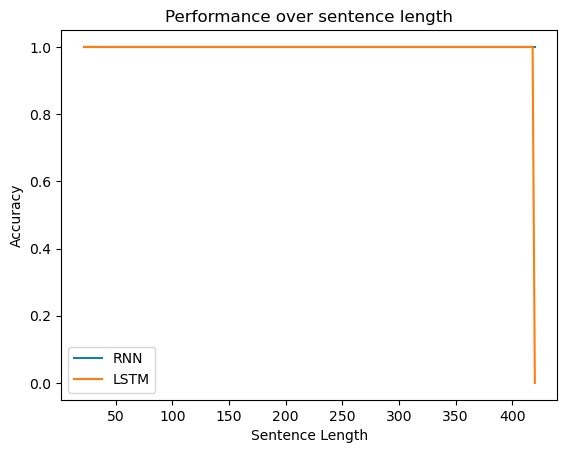

In [61]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the results
ax.plot(rnn_1_lengths, rnn_1_accuracies, label='RNN')
ax.plot(lsmt_1_lengths, lsmt_1_accuracies, label='LSTM')

# Add labels and title
ax.set_xlabel('Sentence Length')
ax.set_ylabel('Accuracy')
ax.set_title('Performance over sentence length')
ax.legend()  # Add a legend

# Show the plot
plt.show()

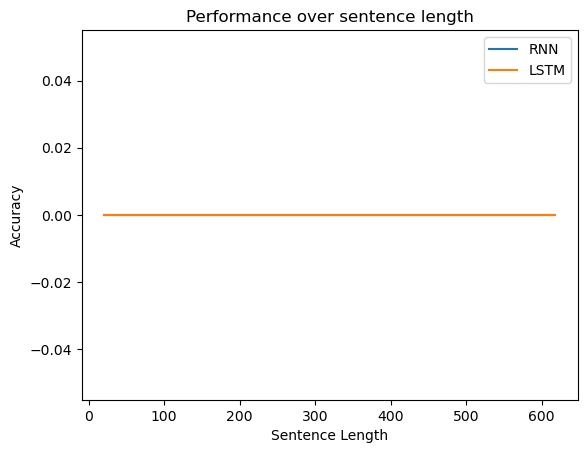

In [62]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the results
ax.plot(rnn_2_lengths, rnn_2_accuracies, label='RNN')
ax.plot(lsmt_2_lengths, lsmt_2_accuracies, label='LSTM')

# Add labels and title
ax.set_xlabel('Sentence Length')
ax.set_ylabel('Accuracy')
ax.set_title('Performance over sentence length')
ax.legend()  # Add a legend

# Show the plot
plt.show()